In [109]:
import time
import random
import pygame
import threading
import numpy as np
import pandas as pd
from person import Person
from datetime import datetime
import matplotlib.pyplot as plt

In [110]:
NUM_PEOPLE = 200
SOCIAL_DISTANCE_PERCENTAGE = 0.75

In [111]:
healthyBIN, infectedBIN, recoveredBIN, dailyINFECTIONS, dailyRECOVERIES, rawHealthy, rawInfected, rawRecovered = [], [], [], [], [], [], [], []
lastSeenInfected = 1
lastSeenRecovered = -1

In [112]:
def percentage(part, whole):
    Percentage = 100 * float(part)/float(whole)
    return str(Percentage) + '%'

def calculateCases(people):
    global lastSeenInfected, lastSeenRecovered
    recovered = 0
    infected = 0
    healthy = 0
    for boi in people:
        if boi.status == "sick":
            infected += 1
        elif boi.status == "recovered":
            recovered += 1
        else:
            healthy += 1
    rawHealthy.append(healthy)
    rawInfected.append(infected)
    rawRecovered.append(recovered)
    if infected - lastSeenInfected > 0:
        dailyINFECTIONS.append(infected - lastSeenInfected)
        lastSeenInfected = infected
    else:
        dailyINFECTIONS.append(0)
    if recovered - lastSeenRecovered > 0:
        dailyRECOVERIES.append(recovered - lastSeenRecovered)
        lastSeenRecovered = recovered
    else:
        dailyRECOVERIES.append(0)
        
    return (healthy, infected, recovered)

def timeToEradicate(start):
    now = datetime.now()
    seconds = (now - start).total_seconds()
    print(f"Time to eradicate: {seconds}")

def statistics(numPeople, healthy, infected, recovered):
    global dailyINFECTIONS, dailyRECOVERIES
    healthyBIN.append(percentage(healthy, numPeople))
    infectedBIN.append(percentage(infected, numPeople))
    recoveredBIN.append(percentage(recovered, numPeople))

In [113]:
def main():
    global SOCIAL_DISTANCE_PERCENTAGE, NUM_PEOPLE
    pygame.init()
    HEIGHT = 600
    WIDTH = 800
    screen = pygame.display.set_mode([WIDTH, HEIGHT])
    pygame.display.set_caption('Virus Simulation')
    screen.fill(pygame.Color("grey"))

    clock = pygame.time.Clock()
    MAX_FPS = 30
    numPeople = NUM_PEOPLE
    factorOfPeopleSocialDistancing = SOCIAL_DISTANCE_PERCENTAGE

    running = True
    bufferSpawn = 10

    patientZero = Person(random.randint(bufferSpawn, WIDTH-bufferSpawn),  random.randint(bufferSpawn, HEIGHT-bufferSpawn), "sick", False)
    people = [patientZero]

    for i in range(numPeople -1):
        socialDistancing = False
        if i < factorOfPeopleSocialDistancing * numPeople:
            socialDistancing = True 

        colliding = True
        while colliding:
            person = Person(random.randint(bufferSpawn, WIDTH-bufferSpawn), random.randint(bufferSpawn, HEIGHT-bufferSpawn), "healthy", socialDistancing)
            colliding = False 
            for boi in people:
                if person.checkColidingWithOther(boi):
                    colliding = True
                    break
        people.append(person)

    start = datetime.now()

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        for person in people:
            person.update(screen, people)

        screen.fill(pygame.Color("grey"))
        for person in people:
            person.draw(screen)
        pygame.display.flip()

        clock.tick(MAX_FPS)
        healthy, infected, recovered = calculateCases(people)
        statistics(numPeople, healthy, infected, recovered)

        if infected == 0:
            timeToEradicate(start)
            time.sleep(5)
            running = False 

    pygame.quit()

main()

Time to eradicate: 31.489107


In [114]:
parsedHealthyBIN = []
for x in healthyBIN:
    y = ''
    for c in x:
        if c.isdigit():
            y = y + c
    parsedHealthyBIN.append(int(y[:len(y)-1]))

parsedRecoveredBIN = []
for x in recoveredBIN:
    y = ''
    for c in x:
        if c.isdigit():
            y = y + c
    parsedRecoveredBIN.append(int(y[:len(y)-1]))

parsedInfectedBIN = []
for x in infectedBIN:
    y = ''
    for c in x:
        if c.isdigit():
            y = y + c
    parsedInfectedBIN.append(int(y[:len(y)-1]))

In [115]:
from matplotlib.pyplot import figure

In [116]:
df=pd.DataFrame({'Time':range(len(parsedHealthyBIN)), 'Healthy': parsedHealthyBIN, 'Recovered': parsedRecoveredBIN, 'Infected': parsedInfectedBIN})
df = df.iloc[::4]
for i, x in enumerate(df['Time']):
    df['Time'][x] = i + 1
df = df.set_index('Time')

In [117]:
print(plt.style.available)
plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [118]:
def valuesCompressed(values):
    valuesComp = []
    i = 1
    while i < len(values)//10 + 1:
        valuesComp.append(sum(values[(i-1)*10:i*10]))
        i+=1
    return valuesComp      
dailyInfected = valuesCompressed(dailyINFECTIONS)
dailyRecovered = valuesCompressed(dailyRECOVERIES)
time = [x for x in range(len(dailyInfected))]

In [119]:
dfDaily=pd.DataFrame({'Time':range(len(dailyINFECTIONS)), 'DailyInfections': dailyINFECTIONS, 'DailyRecoveries': dailyRECOVERIES})
for i, x in enumerate(dfDaily['Time']):
    dfDaily['Time'][x] = i + 1
dfDaily = dfDaily.set_index('Time')

In [120]:
result = df.tail(1)
result
for x in result['Healthy']:
    print("HEALTHY: " + str(x) + '%')
    print("INFECTED: " + str(100 - x) + '%')
for x in result['Recovered']:
    print("RECOVERED: " + str(x) + '%')
    

HEALTHY: 36%
INFECTED: 64%
RECOVERED: 64%


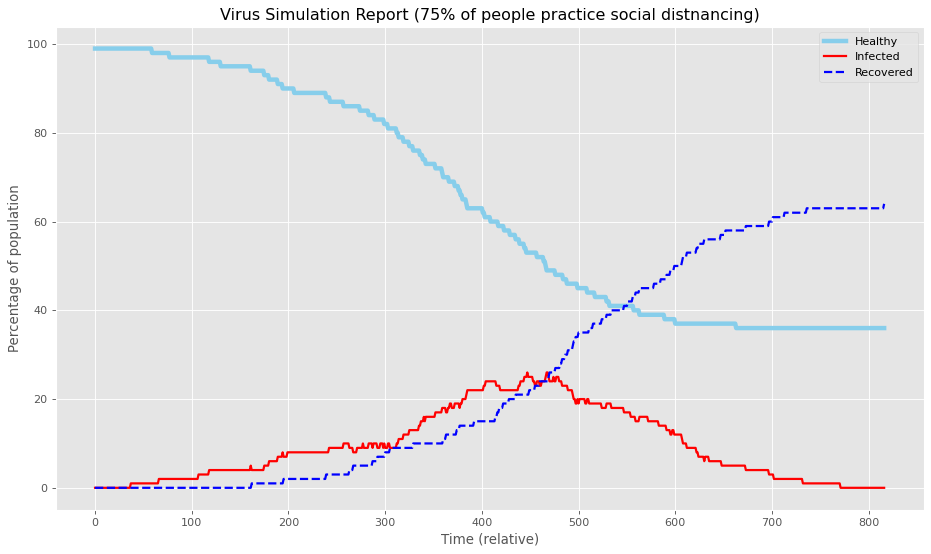

In [121]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
# multiple line plots
plt.plot(range(len(parsedHealthyBIN)), parsedHealthyBIN, marker='', markerfacecolor='white', markersize=12, color='skyblue', linewidth=4, label="Healthy")
plt.plot(range(len(parsedHealthyBIN)), parsedInfectedBIN, marker='', color='red', linewidth=2, label="Infected")
plt.plot(range(len(parsedHealthyBIN)), parsedRecoveredBIN, marker='', color='blue', linewidth=2, linestyle='dashed', label="Recovered")
# show legend
plt.title(f'Virus Simulation Report ({int(SOCIAL_DISTANCE_PERCENTAGE*100)}% of people practice social distnancing)')
plt.xlabel('Time (relative)')
plt.ylabel('Percentage of population')
plt.legend()

# show graph
plt.show()

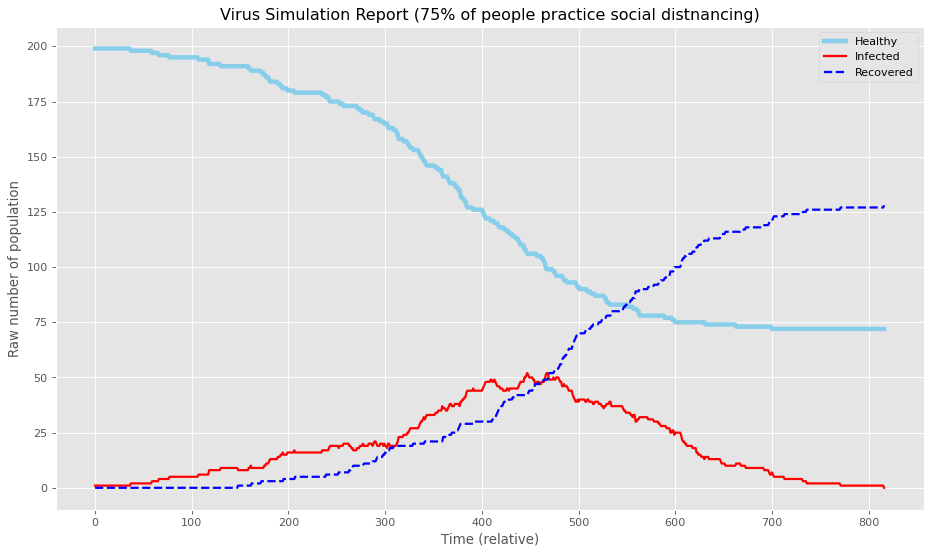

In [122]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
# multiple line plots
plt.plot(range(len(rawHealthy)), rawHealthy, marker='', markerfacecolor='white', markersize=12, color='skyblue', linewidth=4, label="Healthy")
plt.plot(range(len(rawHealthy)), rawInfected, marker='', color='red', linewidth=2, label="Infected")
plt.plot(range(len(rawHealthy)), rawRecovered, marker='', color='blue', linewidth=2, linestyle='dashed', label="Recovered")
# show legend
plt.title(f'Virus Simulation Report ({int(SOCIAL_DISTANCE_PERCENTAGE*100)}% of people practice social distnancing)')
plt.xlabel('Time (relative)')
plt.ylabel('Raw number of population')
plt.legend()

# show graph
plt.show()

In [123]:
#figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
# multiple line plots
#plt.plot(time, dailyInfected, marker='', color='red', linewidth=4, label="Daily Infections")
#plt.plot(time, dailyRecovered, marker='', color='blue', linewidth=2, label="Daily Recoveries")
# show legend
#plt.title('Virus Simulation Report')
#plt.xlabel('Time (relative)')
#plt.ylabel('Daily Change')
#plt.legend()

# show graph
#plt.show()